In [106]:
import numpy as np
from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation, metrics
import urllib2
import matplotlib.pyplot as plt
from scipy.integrate import simps

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib
from sklearn.utils import shuffle ###replace=False
from sklearn.metrics import mean_squared_error
import pandas
from sklearn.metrics import f1_score
import seaborn as sns
from scipy import stats

import bspline
import bspline.splinelab as splinelab
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [4]:
def Addspline(x, D, totaldis):
    p = 3              # order of spline (as-is; 3 = cubic)
    nknots = 11       # number of knots to generate (here endpoints count only once)
    tau = np.linspace(0,1,totaldis+1)  # collocation sites (i.e. where to evaluate)
    knots = np.linspace(0,1,nknots)  # create a knot vector without endpoint repeats
    k     = splinelab.augknt(knots, p)  # add endpoint repeats as appropriate for spline order p
    B     = bspline.Bspline(k, p)  
    D = D/float(max(D))
    bmat = np.zeros((len(D), nknots+p-1))
    for i in range(0,len(D)):
        bmat[i,:] = B.collmat(tau[max(np.where(tau<=D[i])[0])])

    featmatcol = x.shape[1]
    bmatcol = bmat.shape[1]
    out = np.zeros((len(D), featmatcol*bmatcol))
    n = 0
    for i in range(0,featmatcol):
        for j in range(0,bmatcol):
            out[:,n] = x[:,i]*bmat[:,j]
            n+=1
    return out

In [5]:
chrs_length = [249250621,243199373,198022430,191154276,180915260,171115067,159138663,146364022,141213431,135534747,135006516,133851895,115169878,107349540,102531392,90354753,81195210,78077248,59128983,63025520,48129895,51304566]
lowerbound = 0
totaldis = 200
res1 = 25000
resn1 = '25kb'
celltype1 = 'Gm12878'
celltype2 = 'K562'
celltype3 = 'Hmec'
celltype4 = 'Huvec'
celltype11 = 'Gm12878_primary'
celltype12 = 'Gm12878_replicate'

In [6]:
def geninput(lb, td, res, resn, celltype, chrnum, spline=True):
    hicinput = pandas.read_table('/Users/linan/Downloads/'+celltype+'.'+resn+'.'+chrnum+'_KR.matrix', sep='\t', header=None).values
    print 'done with loading Hi-C'
    featinputall = pandas.read_table('/Users/linan/Downloads/'+celltype+'.chip.'+resn+'.withcoord', sep=' ')
    featinput_raw = featinputall.loc[featinputall['CHR']==chrnum].values[:,2::]
    featinput = (featinput_raw-featinput_raw.mean())/featinput_raw.std()
    print 'done with loading feature'
    
    bv = np.intersect1d(np.where(featinput_raw[:,0] >= np.percentile(featinput_raw[:,0],90))[0],np.where(featinput_raw[:,8] >= np.percentile(featinput_raw[:,8],90))[0])
    
    nbin = np.shape(featinput)[0]
    if np.shape(hicinput)[0] != nbin:
        print 'HiC matrix has different row number with feature matrix'
    m,n=np.indices(hicinput.shape)
    ncol = np.shape(featinput)[1]
    outmat = np.empty((0,2*ncol+1), int)
    hicout = np.empty(0)
    ball = np.zeros(nbin)
    btmp = np.zeros(nbin)
    for i in range(lb,td):
        hic = hicinput[m==n-i]
        loc1 = np.copy(featinput[0:nbin-i,:])
        loc2 = np.copy(featinput[i:nbin,:])
        if len(hic) != np.shape(loc1)[0]:
            print 'problem'
        dis = np.array([i]*(nbin-i))
        S = np.column_stack((loc1+loc2,abs(loc1-loc2)))
        sampleATdis = np.column_stack((S,dis))
        hicout = np.append(hicout,hic)
        outmat = np.append(outmat, sampleATdis,axis = 0)
        if i >0:
            btmp = btmp[0:nbin-i]
            btmp[bv[bv<(nbin-i)]] += 1
            ball = np.append(ball,btmp)
    if spline:
        finalout = np.column_stack((Addspline(outmat[:,0:(outmat.shape[1]-1)], outmat[:, outmat.shape[1]-1], td), ball))
        print 'splined'
    else:
        finalout = np.column_stack((outmat,ball))
    return (hicout, finalout, outmat[:,-1])

In [7]:
labelsTrain, featuresTrain, disTrain = geninput(lowerbound, totaldis, res1, resn1, celltype11, 'chr1')

done with loading Hi-C
done with loading feature
splined


In [8]:
labelsTest, featuresTest, disTest = geninput(lowerbound, totaldis, res1, resn1, celltype12, 'chr18')

done with loading Hi-C
done with loading feature
splined


In [9]:
labelsrep, featuresrep, disrep = geninput(lowerbound, totaldis, res1, resn1, celltype11, 'chr18')

done with loading Hi-C
done with loading feature
splined


In [10]:
labelsTest_K562, featuresTest_K562, disTestK562 = geninput(lowerbound, totaldis, res1, resn1, celltype2, 'chr18')

done with loading Hi-C
done with loading feature
splined


In [11]:
labelsTest_Hmec, featuresTest_Hmec, disTestHmec = geninput(lowerbound, totaldis, res1, resn1, celltype3, 'chr18')

done with loading Hi-C
done with loading feature
splined


In [237]:
numoff = np.shape(featuresTrain)[1]
numoftree=200
model = RandomForestRegressor(n_estimators=numoftree, n_jobs=15, max_features=(numoff/3), min_samples_leaf = 3, oob_score="True")
model.fit(featuresTrain, labelsTrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=113L, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=15, oob_score='True',
           random_state=None, verbose=0, warm_start=False)

In [14]:
model2.oob_score_

0.98398572167986498

In [239]:
predictedtestLabels = model.predict(featuresTest)
print 'mse of testing '+str(numoftree),mean_squared_error(labelsTest,predictedtestLabels)

mse of testing 200 5472.67011947


In [15]:
predictedtestLabels_K562 = model2.predict(featuresTest_K562)
print 'mse of testing '+str(numoftree),mean_squared_error(labelsTest_K562,predictedtestLabels_K562)

mse of testing 200 21334.7400547


In [16]:
predictedtestLabels_Hmec = model2.predict(featuresTest_Hmec)
print 'mse of testing '+str(numoftree),mean_squared_error(labelsTest_Hmec,predictedtestLabels_Hmec)

mse of testing 200 51315.9682113


In [17]:
def bydiscor (mat1,mat2,dis,lowerb, totald):
    pcor = [0]*totald
    scor = [0]*totald
    if np.shape(mat1) != np.shape(mat2):
        print "error, shapes are different!"
    for i in range(lowerb,totald):
        hic1 = mat1[np.where(dis==i)]
        hic2 = mat2[np.where(dis==i)]
        pcor[i] = pearsonr(hic1,hic2)[0]
        scor[i] = spearmanr(hic1,hic2)[0]
    return (pcor,scor)

In [245]:
p,s=bydiscor(predictedtestLabels,labelsTest, disTest,lowerbound,totaldis)

In [242]:
pt,st=bydiscor(labelsTest_Hmec,labelsTest, disTest,lowerbound,totaldis)

In [149]:
pr,sr=bydiscor(labelsrep,labelsTest, disTest,lowerbound,totaldis)

In [260]:
pk,sk=bydiscor(labelsTest_K562,labelsTest,disTest,lowerbound,totaldis)

In [262]:
ptp,stp=bydiscor(labelsTest_Hmec,labelsTest, disTest,lowerbound,totaldis)

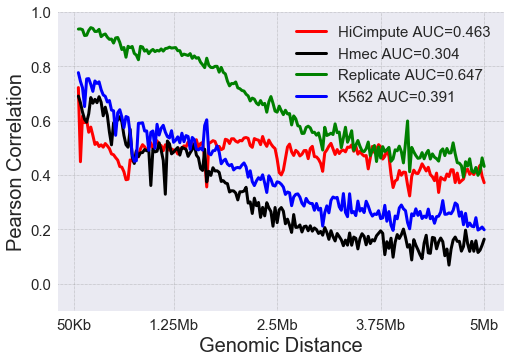

Ttest_indResult(statistic=11.677283945094079, pvalue=2.7110163719546865e-27)
Ttest_indResult(statistic=5.655407424108664, pvalue=2.972957121170917e-08)
Ttest_indResult(statistic=-14.033784222735736, pvalue=1.2449796545324066e-36)


In [359]:
# Plot
fig, ax = plt.subplots()
plt.box(True)
X = range(0, totaldis)
ax.plot(X[2:totaldis-1], p[2:totaldis-1], color='r', label='HiCimpute AUC=%s' % round(simps(p[2:totaldis-1], dx = 0.005),3),linewidth=3)
ax.plot(X[2:totaldis-1], pt[2:totaldis-1], color='k', label='Hmec AUC=%s' % round(simps(pt[2:totaldis-1], dx = 0.005),3),linewidth=3)
ax.plot(X[2:totaldis-1], pr[2:totaldis-1], color='g', label='Replicate AUC=%s' % round(simps(pr[2:totaldis-1], dx = 0.005),3),linewidth=3)
ax.plot(X[2:totaldis-1], pk[2:totaldis-1], color='b', label='K562 AUC=%s' % round(simps(pk[2:totaldis-1], dx = 0.005),3),linewidth=3)
plt.ylim(-0.1,1)

plt.xlabel('Genomic Distance', size=20)
plt.ylabel('Pearson Correlation', size = 20)
plt.yticks(size = 15)
plt.xticks((0,48,98,148,198), ('50Kb', '1.25Mb', '2.5Mb', '3.75Mb', '5Mb'),size = 15)
plt.legend(fontsize = 15)
ax.grid(linestyle=':', linewidth='0.5', color='grey')
plt.savefig("/Users/linan/Desktop/bydis_25kb_krnorm_pearson.png", dpi=300, transparent=True, bbox_inches='tight')
plt.show()
print stats.ttest_ind(p,pt)
print stats.ttest_ind(p,pk)
print stats.ttest_ind(p,pr)

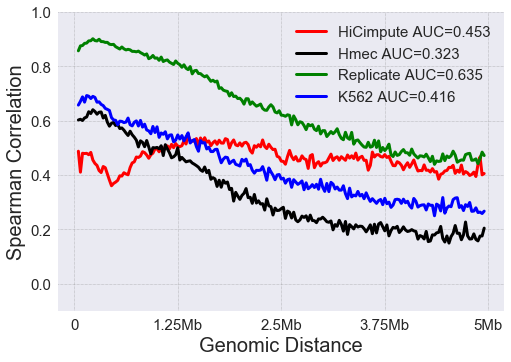

Ttest_indResult(statistic=11.434710077776522, pvalue=2.2457623340545207e-26)
Ttest_indResult(statistic=3.4985622875910813, pvalue=0.00052059757382749369)
Ttest_indResult(statistic=-16.327064968068317, pvalue=3.0846904451818625e-46)


In [361]:
fig, ax = plt.subplots()
plt.box(True)
X = range(0, totaldis)
ax.plot(X[2:totaldis-1], s[2:totaldis-1], color='r', label='HiCimpute AUC=%s' % round(simps(s[2:totaldis-1], dx = 0.005),3),linewidth=3)
ax.plot(X[2:totaldis-1], st[2:totaldis-1], color='k', label='Hmec AUC=%s' % round(simps(st[2:totaldis-1], dx = 0.005),3),linewidth=3)
ax.plot(X[2:totaldis-1], sr[2:totaldis-1], color='g', label='Replicate AUC=%s' % round(simps(sr[2:totaldis-1], dx = 0.005),3),linewidth=3)
ax.plot(X[2:totaldis-1], sk[2:totaldis-1], color='b', label='K562 AUC=%s' % round(simps(sk[2:totaldis-1], dx = 0.005),3),linewidth=3)

#plt.title('By distance correlation')
plt.ylim(-0.1,1)

plt.xlabel('Genomic Distance', size=20)
plt.ylabel('Spearman Correlation', size = 20)
plt.yticks(size = 15)
plt.xticks((0,50,100,150,200), (0, '1.25Mb', '2.5Mb', '3.75Mb', '5Mb'),size = 15)
plt.legend(fontsize = 15)
ax.grid(linestyle=':', linewidth='0.5', color='grey')
plt.savefig("/Users/linan/Desktop/bydis_25kb_krnorm_spearman.png", dpi=300, transparent=True, bbox_inches='tight')
plt.show()
print stats.ttest_ind(s,st)
print stats.ttest_ind(s,sk)
print stats.ttest_ind(s,sr)

In [18]:
def predtomat (plabel, dis, msize, lowerb, totald):
    outmat = np.zeros((msize,msize))
    m,n=np.indices(outmat.shape)
    for i in range(lowerb,totald):
        outmat[m==n-i] = plabel[np.where(dis==i)]
        outmat[m==n+i] = plabel[np.where(dis==i)]
    return outmat

In [248]:
predm = predtomat(predictedtestLabels, disTest, chrs_length[18-1]/res1+1, lowerbound,totaldis)

In [27]:
testm = predtomat(labelsTest, disTest, chrs_length[18-1]/res1+1, lowerbound,totaldis)

In [28]:
hmecm = predtomat(labelsTest_Hmec, disTest, chrs_length[18-1]/res1+1, lowerbound,totaldis)

In [29]:
k562m = predtomat(labelsTest_K562, disTest, chrs_length[18-1]/res1+1, lowerbound,totaldis)

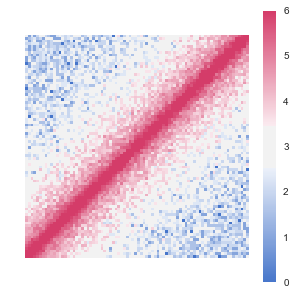

In [128]:
sp = 2230
ep = 2310
testregion = np.copy(simmat[sp:ep,sp:ep])
fig, axs = plt.subplots(1,1,figsize=(5,5))
im = axs.imshow(np.log2(testregion+1), cmap=sns.diverging_palette(255,  0,sep=40,as_cmap = True), interpolation='none', origin='lower', vmax = 6, aspect=1)
plt.axis('off')
fig.colorbar(im)
plt.show()

In [ ]:
###Across cell type#####



In [12]:
numoff = np.shape(featuresTest)[1]
numoftree=200
model2 = RandomForestRegressor(n_estimators=numoftree, n_jobs=15, max_features=(numoff/3), min_samples_leaf = 3, oob_score="True")
model2.fit(featuresTest, labelsTest)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=113L, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=15, oob_score='True',
           random_state=None, verbose=0, warm_start=False)

In [77]:
phmecm = predtomat(predictedtestLabels_Hmec, disTest, chrs_length[18-1]/res1+1, lowerbound,totaldis)

In [19]:
pk562m = predtomat(predictedtestLabels_K562, disTest, chrs_length[18-1]/res1+1, lowerbound,totaldis)

In [126]:
def firstroundsim (msize, totaldis):
    #m,n=np.indices((msize,msize))
    newm = np.zeros((msize,msize))
    for i in range(0,totaldis):
        newm[range(0+i,msize+i)[:(msize-i)], range(0,msize)[:(msize-i)]] = newm[range(0,msize)[:(msize-i)],range(0+i,msize+i)[:(msize-i)]] = np.random.poisson(200.0/(i+1), msize-i) ###200 was calculated from Rao cell 2014
    return newm

In [127]:
simmat = firstroundsim(chrs_length[18-1]/res1+1,totaldis)

In [58]:
chiapet_Gm = np.genfromtxt('/Users/linan/Dropbox/ChiAPET/Gm12878/Gm12878.CTCF.chr18')

In [60]:
chiapet_K562 = np.genfromtxt('/Users/linan/Dropbox/ChiAPET/K562/K562.CTCF.chr18')

In [61]:
chiapet_coord_Gm = np.stack(((chiapet_Gm[:,1]+chiapet_Gm[:,2])/2/res1,(chiapet_Gm[:,4]+chiapet_Gm[:,5])/2/res1), axis=-1)##save chiapet in hic position to array
chiapet_nodup_Gm = np.vstack({tuple(row) for row in chiapet_coord_Gm.astype(int)})###remove multiple chiapet entry in same hic contact

chiapet_coord_K562 = np.stack(((chiapet_K562[:,1]+chiapet_K562[:,2])/2/res1,(chiapet_K562[:,4]+chiapet_K562[:,5])/2/res1), axis=-1)##save chiapet in hic position to array
chiapet_nodup_K562 = np.vstack({tuple(row) for row in chiapet_coord_K562.astype(int)})###remove multiple chiapet entry in same hic contact

In [67]:
##chiapet_nodup = np.array(list(set(map(tuple,chiapet_nodup_K562)) - set(map(tuple,chiapet_nodup_Gm)))) ##K562 unique chiapet

In [99]:
ctcflist_chip = pandas.read_table('/Users/linan/Dropbox/CTCF/K562Ctcf.1bp',sep=' ', header=None)
ctcflist_chip.columns = ["chr", "pos", "direction"]
ctcflist_chip = ctcflist_chip.loc[ctcflist_chip['chr']=='chr18']
ctcflist_chip = ctcflist_chip.values
overlaplist=[]
for j in range(0,ctcflist_chip.shape[0]):
    chippos = ctcflist_chip[j,1]
    for i in range(0,chiapet_K562.shape[0]):
        chiapet_1_1 = chiapet_K562[i,1]
        chiapet_1_2 = chiapet_K562[i,2]
        chiapet_2_1 = chiapet_K562[i,4]
        chiapet_2_2 = chiapet_K562[i,5]
        if chippos <= chiapet_1_2+res1/2 and chippos >= chiapet_1_1-res1/2:
            overlaplist.append(j)
            break
        if chippos <= chiapet_2_1+res1/2 and chippos >= chiapet_2_2-res1/2:
            overlaplist.append(j)
            break
chipnotchiapet = np.delete(ctcflist_chip,overlaplist,axis=0)

In [100]:
truelistloc = []
lowerb = 100000
upperb = 5000000
for chiapos in range(0,chiapet_nodup_K562.shape[0]):
    chiapet_1 = chiapet_nodup_K562[chiapos,0]
    chiapet_2 = chiapet_nodup_K562[chiapos,1]
    if abs(chiapet_2*res1 - chiapet_1*res1) > lowerb and abs(chiapet_2*res1 - chiapet_1*res1) < upperb:
        truelistloc.append((chiapet_1,chiapet_2))
print '########Finish generating truelist########'

########Finish generating truelist########


In [104]:
chipnotchiapet_nodup = np.unique(chipnotchiapet[:,1].astype(int)/res1)
print len(chipnotchiapet_nodup)
print '########Finish removing redundant nonchiapet-hic entries########'
print len(truelistloc)
falselistloc = []
for o in range(0,100):
    nf = 0
    while nf <= len(truelistloc):
        b = np.random.randint(0,chipnotchiapet_nodup.shape[0],2)
        if abs(chipnotchiapet_nodup[b[0]]*res1-chipnotchiapet_nodup[b[1]]*res1) < upperb and abs(chipnotchiapet_nodup[b[0]]*res1-chipnotchiapet_nodup[b[1]]*res1) > lowerb:
            falselistloc.append((min(chipnotchiapet_nodup[b[0]],chipnotchiapet_nodup[b[1]]),max(chipnotchiapet_nodup[b[0]],chipnotchiapet_nodup[b[1]])))
            nf+=1
print '########Finish generating falselist########'

323
########Finish removing redundant nonchiapet-hic entries########
191
########Finish generating falselist########


In [110]:
def standardizemat (hmat1, td):
    hmat = np.copy(hmat1)
    m,n=np.indices(hmat.shape)
    for i in range(0,td):
        s = hmat[m==n-i]
        st = (s-np.mean(s))/np.std(s)
        hmat[m==n-i] = hmat[m==n+i] = st
    return hmat

In [132]:
def getAUC (mm):
    fpr_all=[]
    tpr_all=[]
    auc_score=np.zeros(10)
    hict = standardizemat(mm, totaldis)

    for q in range(0,10):
        truelist=[]
        falselist=[]
        for t in range(0,len(truelistloc)):
            dis1 = abs(truelistloc[t][0] - truelistloc[t][1])
            dis2 = abs(falselistloc[q*len(truelistloc)+t][0] - falselistloc[q*len(truelistloc)+t][1])
            truelist.append(hict[truelistloc[t][0],truelistloc[t][1]])
            falselist.append(hict[falselistloc[q*len(truelistloc)+t][0],falselistloc[q*len(truelistloc)+t][1]])
        y = np.array([1]*len(truelist)+[0]*len(falselist))
        y_score = np.array(truelist+falselist) 
        fpr_rf, tpr_rf, _ = roc_curve(y, y_score)
        fpr_all.append(fpr_rf)
        tpr_all.append(tpr_rf)
        auc_score[q]=roc_auc_score(y, y_score)
    return (fpr_all, tpr_all, auc_score)

In [133]:
fpr_k562, tpr_k562, auc_k562 = getAUC(k562m)

In [135]:
fpr_pk562, tpr_pk562, auc_pk562 = getAUC(pk562m)

In [136]:
fpr_simu, tpr_simu, auc_simu = getAUC(simmat)

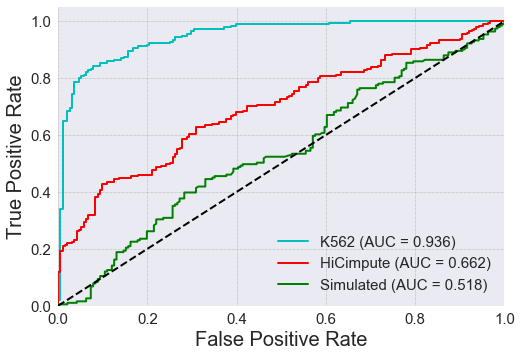

In [141]:
# Plot all ROC curves
fig, ax = plt.subplots()

ax.plot(fpr_k562[2], tpr_k562[2], color='c', lw=2,
             label='K562 (AUC = {1:0.3f})'
             ''.format(2, np.mean(auc_k562)))
ax.plot(fpr_pk562[2], tpr_pk562[2], color='r', lw=2,
             label='HiCimpute (AUC = {1:0.3f})'
             ''.format(2, np.mean(auc_pk562)))
ax.plot(fpr_simu[2], tpr_simu[2], color='g', lw=2,
             label='Simulated (AUC = {1:0.3f})'
             ''.format(2, np.mean(auc_simu)))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend(loc="lower right", fontsize=15)
ax.grid(linestyle=':', linewidth='0.5', color='grey')
plt.savefig("/Users/linan/Desktop/ROC.png", dpi=300, transparent=True, bbox_inches='tight')
plt.show()

In [ ]:
######Feature Importance######




In [90]:
fi = model2.feature_importances_

In [91]:
fisumspline = np.add.reduceat(fi[0:len(fi)-1], np.arange(0, len(fi)-1, 13))

In [92]:
fisum = np.append(fisumspline[0:13]+fisumspline[13::], fi[-1])

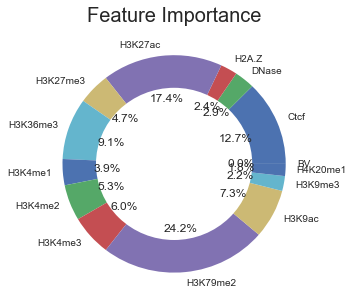

In [93]:
fig1, ax1 = plt.subplots(figsize=(5,5))
labels = np.append(pandas.read_table('/Users/linan/Downloads/'+celltype1+'.chip.'+resn1+'.withcoord', sep=' ').columns.values[2::], np.array(['BV']))
ax1.pie(fisum, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 12})
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Feature Importance', fontsize=20)
#plt.savefig("/Users/linan/Desktop/featureimportance.png", dpi=300, transparent=True, bbox_inches='tight')
plt.show()

In [352]:
def featimportspline (fi):
    p = 3              # order of spline (as-is; 3 = cubic)
    nknots = 11       # number of knots to generate (here endpoints count only once)
    tau = np.linspace(0,1,totaldis+1)  # collocation sites (i.e. where to evaluate)
    knots = np.linspace(0,1,nknots)  # create a knot vector without endpoint repeats
    k     = splinelab.augknt(knots, p)  # add endpoint repeats as appropriate for spline order p
    B     = bspline.Bspline(k, p)
    outall = np.empty((0,len(tau)))
    for feati in range(0,13):
        fi_onef = fi[feati*13:(feati+1)*13]+fi[(13+feati)*13:(13+feati+1)*13]
        out = np.zeros(len(tau))
        for dis in range(0,len(tau)):
            out[dis] = sum(fi_onef * Bt.collmat(tau[dis]))
        outall = np.vstack((outall, out))
    return outall/np.sum(outall,axis=0)

In [325]:
labels

array(['Ctcf', 'DNase', 'H2A.Z', 'H3K27ac', 'H3K27me3', 'H3K36me3',
       'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K79me2', 'H3K9ac', 'H3K9me3',
       'H4K20me1', 'BV'], dtype=object)

C:\Users\linan\Anaconda2\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app


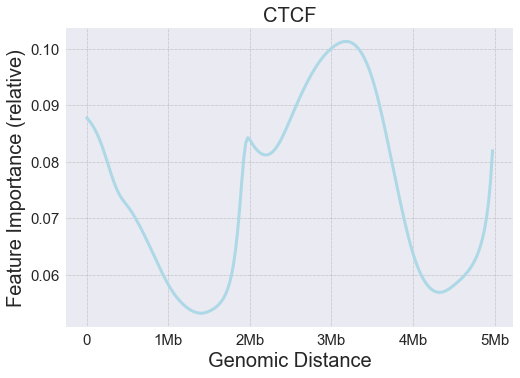

In [400]:
i=5
fig, ax = plt.subplots()
plt.plot(np.linspace(0,1,totaldis+1), featimportspline(fi)[i],linewidth=3, color = '#ADD8E6')
plt.xlabel('Genomic Distance', size=20)
plt.ylabel('Feature Importance (relative)', size = 20)
plt.yticks(size = 15)
plt.xticks((0,0.2,0.4,0.6,0.8,1), (0, '1Mb','2Mb','3Mb', '4Mb', '5Mb'),size = 15)
plt.legend(fontsize = 15)
plt.title('CTCF', fontsize=20)
ax.grid(linestyle=':', linewidth='0.5', color='grey')
plt.savefig("/Users/linan/Desktop/H3K36me3fi.png", dpi=300, transparent=True, bbox_inches='tight')
plt.show()